In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from playsound import playsound
import time
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0


In [3]:
seq_len = 32

# model 불러오기

In [12]:
model = tf.keras.models.load_model('C:/Users/tnldl/Desktop/Coding/AI_yang/CNN+Bi-LSTM.hdf5')

OSError: SavedModel file does not exist at: C:/Users/tnldl/Desktop/Coding/AI_yang/CNN+Bi-LSTM.hdf5\{saved_model.pbtxt|saved_model.pb}

# data 불러오기

In [ ]:
data_path = 'C:/Users/tnldl/Desktop/Coding/AI_yang/data/036570.xlsx'

df = pd.read_excel(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

df = df.loc[13:]
# copy_df = df.copy()

# data 일단 그려보기

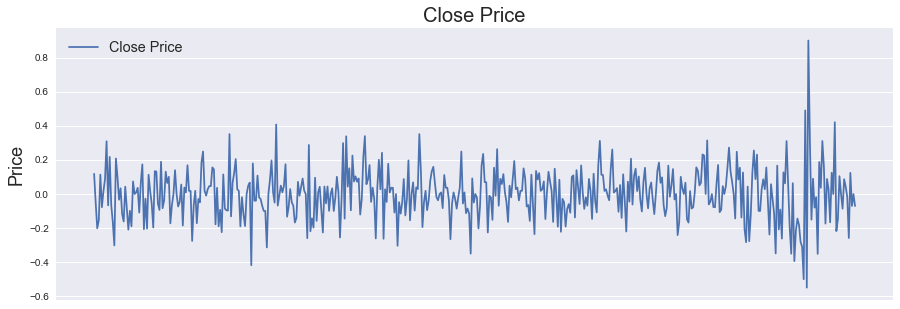

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

# data 전처리

In [ ]:
# pct change
df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True)

'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

Training data shape: (637, 5)
Validation data shape: (80, 5)
Test data shape: (79, 5)
(621, 16, 5) (621,)
(64, 16, 5) (64,)


# model 학습시키기

In [ ]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

# Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
model.fit(X_train, y_train,
              batch_size=16,
              verbose=1,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)

# CNN + Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
model.fit(X_train, y_train,
              batch_size=16,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

# Moving Average Bi-LSTM model

In [ ]:
data_path = 'C:/Users/tnldl/Desktop/Coding/AI_yang/data/036570.xlsx'

df = pd.read_excel(data_path) 
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

df = df.loc[13:]

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(3).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


Training data shape: (4147, 5)
Validation data shape: (518, 5)
Test data shape: (518, 5)
(4115, 32, 5) (4115,)
(486, 32, 5) (486,)


In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
model.fit(X_train, y_train,
              batch_size=32,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

Epoch 1/200
129/129 - 8s - loss: 0.0027 - mae: 0.0314 - mape: 6.6839 - val_loss: 3.6204e-04 - val_mae: 0.0154 - val_mape: 1.9417

Epoch 00001: val_loss improved from inf to 0.00036, saving model to Bi-LSTM.hdf5
Epoch 2/200
129/129 - 3s - loss: 0.0013 - mae: 0.0243 - mape: 5.4655 - val_loss: 4.4433e-04 - val_mae: 0.0169 - val_mape: 2.1675

Epoch 00002: val_loss did not improve from 0.00036
Epoch 3/200
129/129 - 3s - loss: 0.0013 - mae: 0.0246 - mape: 5.5291 - val_loss: 3.6877e-04 - val_mae: 0.0155 - val_mape: 1.9529

Epoch 00003: val_loss did not improve from 0.00036
Epoch 4/200
129/129 - 3s - loss: 0.0013 - mae: 0.0245 - mape: 5.5157 - val_loss: 3.5635e-04 - val_mae: 0.0153 - val_mape: 1.9470

Epoch 00004: val_loss improved from 0.00036 to 0.00036, saving model to Bi-LSTM.hdf5
Epoch 5/200
129/129 - 3s - loss: 0.0013 - mae: 0.0244 - mape: 5.5212 - val_loss: 3.5264e-04 - val_mae: 0.0152 - val_mape: 1.9355

Epoch 00005: val_loss improved from 0.00036 to 0.00035, saving model to Bi-LSTM.hd

# Moving Average CNN + Bi-LSTM model

In [13]:
data_path = 'C:/Users/tnldl/Desktop/Coding/AI_yang/data/036570.xlsx'

df = pd.read_excel(data_path) 
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

df = df.loc[13:]

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(3).mean() 
tmp_df = df.copy()

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


Training data shape: (4147, 5)
Validation data shape: (518, 5)
Test data shape: (518, 5)
(4115, 32, 5) (4115,)
(486, 32, 5) (486,)


In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
model.fit(X_train, y_train,
              batch_size=32,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),) 

Epoch 1/200
129/129 - 27s - loss: 0.0029 - mae: 0.0331 - mape: 6.6070 - val_loss: 4.3648e-04 - val_mae: 0.0168 - val_mape: 2.1053

Epoch 00001: val_loss improved from inf to 0.00044, saving model to CNN+Bi-LSTM.hdf5
Epoch 2/200
129/129 - 10s - loss: 0.0013 - mae: 0.0240 - mape: 5.4621 - val_loss: 5.0602e-04 - val_mae: 0.0181 - val_mape: 2.2709

Epoch 00002: val_loss did not improve from 0.00044
Epoch 3/200
129/129 - 9s - loss: 0.0012 - mae: 0.0232 - mape: 5.3468 - val_loss: 4.3988e-04 - val_mae: 0.0169 - val_mape: 2.1627

Epoch 00003: val_loss did not improve from 0.00044
Epoch 4/200
129/129 - 8s - loss: 0.0011 - mae: 0.0224 - mape: 5.2301 - val_loss: 3.9223e-04 - val_mae: 0.0160 - val_mape: 2.0444

Epoch 00004: val_loss improved from 0.00044 to 0.00039, saving model to CNN+Bi-LSTM.hdf5
Epoch 5/200
129/129 - 8s - loss: 0.0010 - mae: 0.0212 - mape: 4.9890 - val_loss: 0.0016 - val_mae: 0.0364 - val_mape: 4.6703

Epoch 00005: val_loss did not improve from 0.00039
Epoch 6/200
129/129 - 9s 

# 설계된 모델 검증

In [ ]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0003, MAE: 0.0139, MAPE: 1.7937
Validation Data - Loss: 0.0002, MAE: 0.0108, MAPE: 1.3838
Test Data - Loss: 0.0002, MAE: 0.0117, MAPE: 1.4912


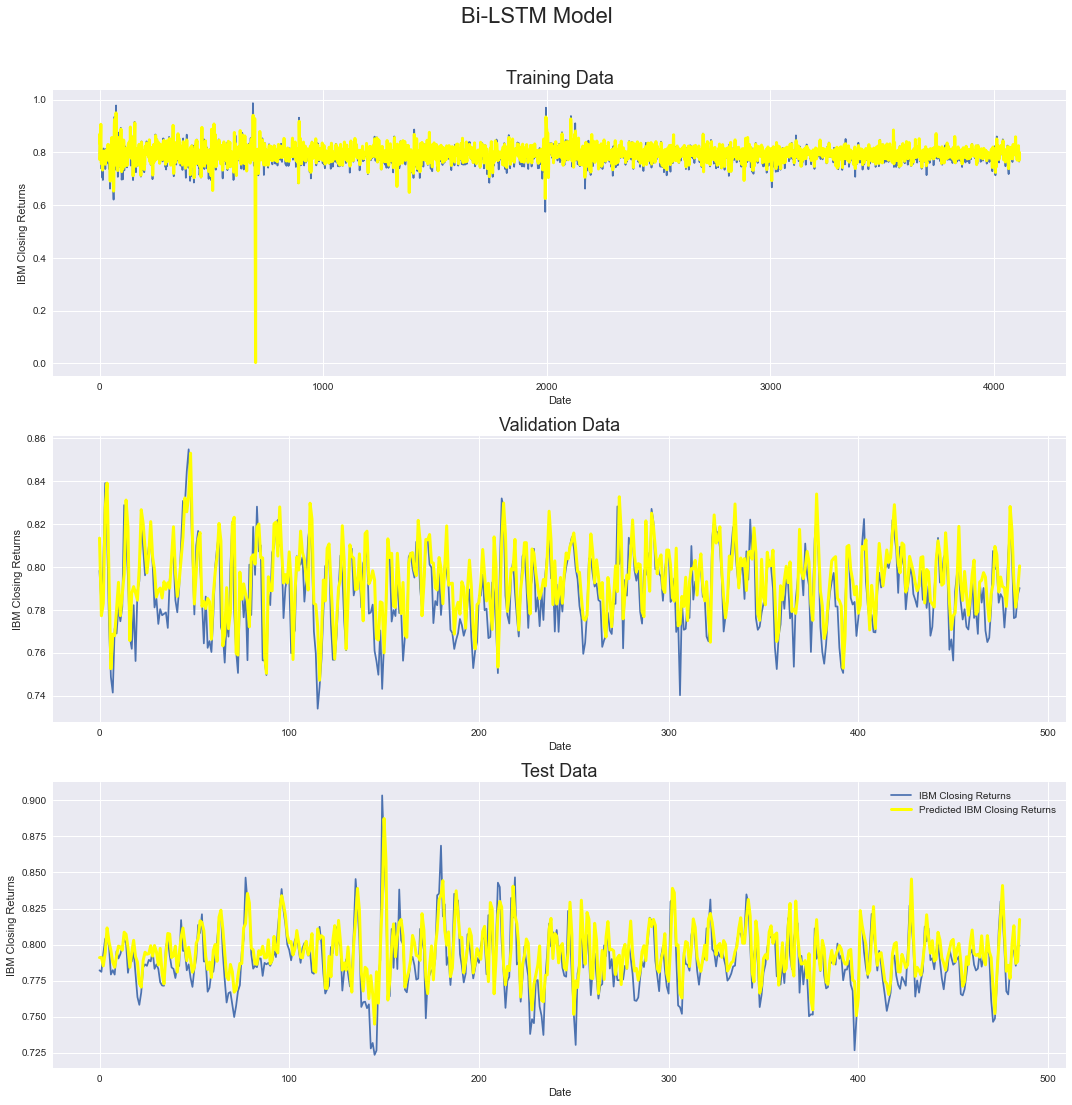

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[seq_len:, 3], label='IBM Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[seq_len:, 3], label='IBM Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[seq_len:, 3], label='IBM Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')

plt.tight_layout()
plt.legend(loc='best')

# BackTesting을 위한 DF 생성

In [14]:
tmp_df.to_excel('MA.xlsx')

In [15]:
def denormalize(df_column):
    for i in range(len(df_column)):
        df_column[i:i+1] = df_column[i:i+1]*(max_return - min_return) + min_return

denormalize(df['Open'])
denormalize(df['High'])
denormalize(df['Low'])
denormalize(df['Close'])

df.to_excel('denormalize_df.xlsx')

#### 원본과 MA, denormalize excel 파일을 합치세요. 만약 ticker나 MA값이 변하지 않았다면 데이터는 그대로 사용해도 괜찮습니다. 

In [ ]:
pred_result = pd.DataFrame(test_pred)
denormalize(pred_result)
pred_result # MA

pred_result.to_excel('prediction.xlsx')

In [57]:
# for i in range(seq_len):
#     tmp_df.append(None)
# tmp_df = pd.DataFrame(tmp_df)
# data_pred = pd.concat([tmp_df,data_pred], axis=0)
# data_pred.reset_index(inplace=True)
# data_pred.drop(columns=['index'], inplace=True)
# copy_df.reset_index(inplace=True)
# copy_df.drop(columns=['index'], inplace=True)

# df_final = pd.concat([copy_df,data_pred], axis=1)
# df_final.to_excel(excel_writer='practice.xlsx')

# RoR 계산하기

In [4]:
data_path = 'C:/Users/tnldl/Desktop/Coding/AI_yang/036570.xlsx'

df = pd.read_excel(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close','Volume', 'MA_open','MA_high','MA_low','MA_close','MA_volume','denormalize_close','Prediction', 'pred_MA_close','Result','Condition']
# Replace 0 to avoid dividing by 0 later on

df.sort_values('Date', inplace=True)

df = df.dropna()

condition = df['Condition']
condition = pd.array(condition)
condition[0]

df_open = df['Open']
df_open = pd.array(df_open)

condition_len = len(df['Condition'])

In [6]:
p = [] # 팔아야 할때
q = [] # 사야할 때
for i in range(0,condition_len-1) :
    if condition[i] < condition[i+1] :
        q.append(df_open[i+1])

    if condition[i] > condition[i+1] :
        p.append(df_open[i+1])

if condition[0] == 1:
    del p[0]

ror=1

for i in range(len(p)) :
    ror = ror*p[i]/q[i]

ror = ror * 0.995**len(q) # 매매 수수료를 고려한 case
print(ror)

1.2158350553531616
